# Getting started

Install the requirements:

In [4]:
!python3 -m pip install -r requirements.txt -q

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import kaggle_environments
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from kaggle_environments import evaluate, make, utils

## Random

In [17]:
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from kaggle_environments import evaluate, make, utils
import numpy as np
actions = np.array(["EAST", "SOUTH", "NORTH", "WEST"])
opp_actions = {'EAST': 'WEST', 'WEST': 'EAST', 'NORTH':'SOUTH', 'SOUTH':'NORTH'}

# Creates a class for an agent so we can keep track of the last action
class RandomAgent:
    def __init__(self, configuration: Configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation: Observation):
        action = np.random.choice(actions) 
        while action == opp_actions.get(self.last_action, ""):
            action = np.random.choice(actions)
        self.last_action = action
        return action

cached_random_agents = {}
def random_agent(obs, config):
    index = obs["index"]
    if index not in cached_random_agents:
        cached_random_agents[index] = RandomAgent(Configuration(config))
    return cached_random_agents[index](Observation(obs))

## Greedy

In [19]:
from kaggle_environments.envs.hungry_geese.hungry_geese import GreedyAgent
cached_greedy_agents = {}

def greedy_agent(obs, config):
    index = obs["index"]
    if index not in cached_greedy_agents:
        cached_greedy_agents[index] = GreedyAgent(Configuration(config))
    return cached_greedy_agents[index](Observation(obs))

agents = {random_agent, agent, greedy_agent}

The agent colors are: White, Blue, Green, Red 

In [20]:
env = make("hungry_geese", debug=True)
steps = env.run([greedy_agent,random_agent, agent])  
#print(steps)
out = env.render(mode="ipython", width=500, height=450)

Goose Collision: WEST
Goose Collision: EAST


## DQN

In [46]:
# The dqn agent is in the python file since it's source code is quite long
dqn_agent = "agent_dqn_1_1.py"

## Run some trials

Code adapted from [here](https://www.kaggle.com/ihelon/hungry-geese-agents-comparison?select=simple_toward.py)

In [117]:
import collections
def simulate_winner(agents, num_episodes=100, debug=False):
    n_agents = len(agents)
    scores = np.zeros((n_agents, n_agents), dtype=np.int)
    
    print("Simulation of battles. It can take some time...")
    for ind_1 in range(n_agents):
        for ind_2 in range(ind_1 + 1, n_agents):
            if debug:
                print(f"LOG: {agents[ind_1]} vs {agents[ind_2]}")
            
            current_score = evaluate(
                "hungry_geese", 
                [
                    agents[ind_1], 
                    agents[ind_2], 
                ],
                num_episodes=num_episodes,
            )

            episode_winners = np.argmax(current_score, axis=1)
            episode_winner_counts = collections.Counter(episode_winners)
            scores[ind_1, ind_2] = episode_winner_counts.get(0, 0)
            scores[ind_2, ind_1] = episode_winner_counts.get(1, 0)
            # return current_score, episode_winners, episode_winner_counts, scores
        if debug:
            print()
    return scores

In [125]:
import pandas as pd
import seaborn as sns
sns.set()

def visualize_scores(scores, x_agents, y_agents, title):
    df_scores = pd.DataFrame(
        scores, 
        index=x_agents, 
        columns=y_agents,
    )

    plt.figure(figsize=(5, 5))
    sns.heatmap(
        df_scores, annot=True, cbar=True, 
        cmap='coolwarm', linewidths=1, 
        linecolor='black', fmt="d",
        cbar_kws={'label': "Amount of wins"}
    )
    plt.xlabel("Loser")
    plt.ylabel("Winner")
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.title(title, fontsize=18)
    
    plt.show()

In [119]:
%%ttime
list_names = ["Greedy", "Random", "DQN"]
scores = simulate_winner([greedy_agent, random_agent, dqn_agent])

Simulation of battles. It can take some time...


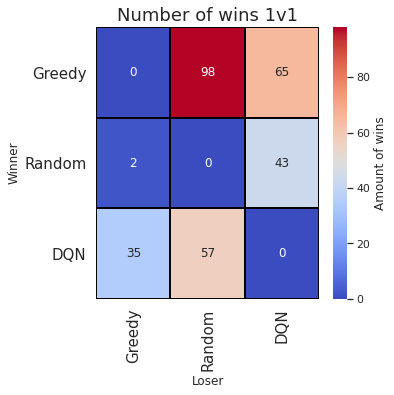

In [124]:
visualize_scores(scores, list_names, list_names, "Number of wins 1v1")

Not so bad!

## TODO: fix draws
Note that any draws will be counter for the smaller index (ie, first in the cols/rows) agent - could be fixed later

